In [1]:
import torch
import glob
import json
import os

import pandas as pd
import torch
import numpy as np


In [2]:

bf_folders = sorted(glob.glob("/proj/haste_berzelius/exps/specs_non_grit_based/*bf*"))[:5]
fl_folders = sorted(glob.glob("/proj/haste_berzelius/exps/specs_non_grit_based/*fl*"))
print(bf_folders, fl_folders)

['/proj/haste_berzelius/exps/specs_non_grit_based/bf_exps_1_split1', '/proj/haste_berzelius/exps/specs_non_grit_based/bf_exps_1_split2', '/proj/haste_berzelius/exps/specs_non_grit_based/bf_exps_1_split3', '/proj/haste_berzelius/exps/specs_non_grit_based/bf_exps_1_split4', '/proj/haste_berzelius/exps/specs_non_grit_based/bf_exps_1_split5'] ['/proj/haste_berzelius/exps/specs_non_grit_based/fl_exps_1_split1', '/proj/haste_berzelius/exps/specs_non_grit_based/fl_exps_1_split2', '/proj/haste_berzelius/exps/specs_non_grit_based/fl_exps_1_split3', '/proj/haste_berzelius/exps/specs_non_grit_based/fl_exps_1_split4', '/proj/haste_berzelius/exps/specs_non_grit_based/fl_exps_1_split5']


In [3]:
from sklearn import preprocessing, decomposition
from utils.cka.cka_features import CKA

bf_exp_folder = os.path.join(bf_folders[1], "bf_11cls_basic_aug_dmsonorm_750e_sgd/ResNet_resnet50/")

site_conversion = pd.DataFrame(
    {"bf_sites": ["s1", "s2", "s3", "s4", "s5"], "f_sites": ["s2", "s4", "s5", "s6", "s8"]}
)

cp_df_cell = pd.read_csv("stats/non_grit_based/CP_features_cells.csv")
print(cp_df_cell.shape)


train_df = pd.read_csv(os.path.join(bf_exp_folder, "feature_data_train.csv"))
train_df["site"] = train_df["site"].map(site_conversion.set_index("bf_sites")["f_sites"])
print(train_df.shape)
cp_bf_df  = pd.merge(train_df, cp_df_cell, on=["plate", "well", "compound", "moa", "site"])
cp_train_df = cp_bf_df[cp_df_cell.columns]
print(cp_train_df.shape)


test_df = pd.read_csv(os.path.join(bf_exp_folder, "feature_data_test.csv"))
test_df["site"] = test_df["site"].map(site_conversion.set_index("bf_sites")["f_sites"])
print(test_df.shape)
cp_bf_df  = pd.merge(test_df, cp_df_cell, on=["plate", "well", "compound", "moa", "site"])
cp_test_df = cp_bf_df[cp_df_cell.columns]

model_feature_columns = [f"fv_{i}" for i in range(2048)]
model_test_features = cp_bf_df[model_feature_columns].values
# model_test_features = decomposition.PCA(n_components=128).fit_transform(model_test_features)
model_test_features = preprocessing.StandardScaler().fit_transform(model_test_features)
print(cp_test_df.shape)



(7676, 678)
(5070, 2054)
(5047, 678)
(1470, 2054)
(1464, 678)


In [4]:
from sklearn.impute import SimpleImputer

feature_groups = ['AreaShape', 'Correlation', 'Granularity', 'Intensity', 'Neighbors', 'RadialDistribution']
cp_columns = [c for c in cp_df_cell.columns if c.startswith(tuple(feature_groups))]

le  = preprocessing.LabelEncoder()
le.fit(cp_train_df["moa"])
cp_train_df["moa_label"] = le.transform(cp_train_df["moa"])
cp_test_df["moa_label"] = le.transform(cp_test_df["moa"])

train_X = cp_train_df[cp_columns].values
cp_norm = preprocessing.StandardScaler().fit(train_X)
train_X = cp_norm.transform(train_X)
train_Y = cp_train_df["moa_label"].values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_X = imp.fit_transform(train_X)
print(train_X.shape, train_Y.shape)

test_X = cp_test_df[cp_columns].values
test_X = cp_norm.transform(test_X)
test_Y = cp_test_df["moa_label"].values
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
test_X = imp.fit_transform(test_X)
print(test_X.shape, test_Y.shape)

(5047, 672) (5047,)
(1464, 672) (1464,)


/tmp/ipykernel_3248896/593990568.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cp_test_df["moa_label"] = le.transform(cp_test_df["moa"])


In [5]:
from random import sample
import torch, torchvision
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

cp_model = nn.Sequential(
    nn.Linear(672, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 11),
    )
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cp_model.parameters())
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X).float(), 
                                        torch.from_numpy(train_Y).long())
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(test_X).float(),
                                        torch.from_numpy(test_Y).long())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

loss_list = []
for i in range(700):
    cp_model.train()
    running_total_loss = 0
    for _, sample in enumerate(train_loader):
        optimizer.zero_grad()
        op = cp_model(sample[0])
        loss = criterion(op, sample[1])
        loss.backward()
        optimizer.step()
        running_total_loss += loss.item()
        loss_list.append(loss.item())
        # plt.plot(loss_list)
    # print("Epoch Loss:", running_total_loss/len(train_loader))

    if i % 50 == 0:
        cp_model.eval()
        accuracy = 0
        for _, sample in enumerate(test_loader):
            op = cp_model(sample[0])
            loss = criterion(op, sample[1])
            accuracy += (torch.argmax(op, dim=1) == sample[1]).sum().item()
        print("Accuracy:", accuracy/len(test_loader.dataset))

Accuracy: 0.5710382513661202
Accuracy: 0.7950819672131147
Accuracy: 0.8101092896174863
Accuracy: 0.8012295081967213
Accuracy: 0.8114754098360656
Accuracy: 0.8094262295081968
Accuracy: 0.8080601092896175
Accuracy: 0.8189890710382514
Accuracy: 0.8142076502732241
Accuracy: 0.8114754098360656
Accuracy: 0.8114754098360656
Accuracy: 0.8189890710382514
Accuracy: 0.8224043715846995
Accuracy: 0.8189890710382514


In [6]:
from sklearn.metrics import classification_report, confusion_matrix

outputs = []
targets = []
with torch.no_grad():
    cp_model.eval()
    for _, sample in enumerate(test_loader):
        target = sample[1]
        op = cp_model(sample[0])
        _, pred = torch.max(op, 1)
        outputs.append(pred)
        targets.append(target)
outputs = torch.cat(outputs).cpu().numpy()
targets = torch.cat(targets).cpu().numpy()

outputs = le.inverse_transform(outputs)
targets = le.inverse_transform(targets)

print(classification_report(targets, outputs))
# print(confusion_matrix(targets, outputs))

                                  precision    recall  f1-score   support

                ATPase inhibitor       0.55      0.61      0.58        87
         Aurora kinase inhibitor       0.77      0.39      0.52       117
                  HDAC inhibitor       0.79      0.97      0.87       180
                   HSP inhibitor       0.75      0.72      0.74       120
                   JAK inhibitor       0.82      0.81      0.81       150
                  PARP inhibitor       0.95      0.96      0.95       120
                            dmso       0.79      0.88      0.83       180
     protein synthesis inhibitor       0.78      0.78      0.78       120
       retinoid receptor agonist       0.90      1.00      0.95        90
         topoisomerase inhibitor       0.95      0.84      0.89       180
tubulin polymerization inhibitor       0.96      0.99      0.98       120

                        accuracy                           0.83      1464
                       macro avg    

(256, 672)


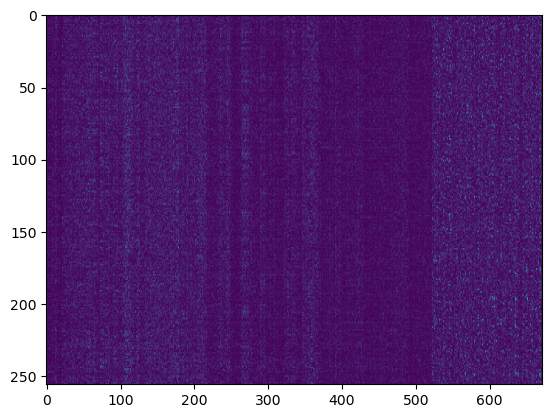

In [7]:
a = np.abs(cp_model[0].weight.detach().numpy())
a = (a - a.min())/(a.max() - a.min())
print(a.shape)
plt.imshow(a, aspect="auto")

In [8]:
cp_model.eval()

cp_test_features = cp_model[:3](torch.from_numpy(test_X).float()).detach().numpy()
cp_test_features = preprocessing.StandardScaler().fit_transform(cp_test_features)
# print(cp_test_features.shape, cp_test_features[1])

In [9]:
cka = CKA()
linear_cka = cka.linear_CKA(cp_test_features, model_test_features)
kernel_cka = cka.kernel_CKA(cp_test_features, model_test_features)
print(linear_cka, kernel_cka)

19.240714075236397
62.29303519016729
19.240714075236397
19.240714075236397
62.29303519016729
62.29303519016729
0.40047495364642366 0.47567207119100574
